In [2]:
#@title { form-width: "5%" }
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from google.colab import drive
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from time import time
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from random import seed
from random import randrange
import pandas as pd
 


drive.mount('/content/gdrive')

%cd gdrive/My Drive/Project ML

tf.logging.set_verbosity(tf.logging.INFO)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Project ML


In [0]:
"""Load Training Data with Returning Features and Labels"""

def load_data_dummy(size):
  #load data

  images_path = os.listdir('progress 1/dummy_data/')
  
  label_map = {'free':[1,0,0],'thin':[0,1,0],'thick': [0,0,1]}
  feature = []
  label = []

  for file_name in images_path:
    
    # Read image file
    temp = cv2.imread('progress 1/dummy_data/' + file_name)
    
    # Resize image
    im_resize = cv2.resize(temp,(size,size))
    feature.append(im_resize)
    
    # Append labels.
    label.append(label_map[file_name.split('_')[0]])
   
  label = np.array(label).astype(float)
  return np.array(feature) / 255.0, label

def load_data(size, test_pct = 0.2):
  #load data
  
  prefix_dir = 'data/size_500/'

  target_path = os.listdir(prefix_dir)
  
  label_map = {'free':[1,0,0],'thin':[0,1,0],'thick': [0,0,1]}
  feature = []
  label = []
  for target in target_path:
    # List images
    images_path = os.listdir(prefix_dir + target)
    
    for file_name in tqdm(images_path):
      
      # Read image file
      temp = cv2.imread(prefix_dir + target + '/' + file_name)
      
      # Resize image
      im_resize = cv2.resize(temp,(size,size))
      feature.append(im_resize)

      # Append labels.
      label.append(label_map[target])
  
  # Convert to numpy array
  train_feature = np.array(feature) / 255.0
  train_label = np.array(label).astype(float)
  
  # Get test data
  test_index = random.sample(range(len(label)), int(len(label) * test_pct))
  test_feature = train_feature[test_index]
  test_label = train_label[test_index]
  
  # Delete test data from train data
  train_feature = np.delete(train_feature, test_index, 0) 
  train_label = np.delete(train_label, test_index, 0)
  
  return train_feature, train_label, test_feature, test_label

In [0]:
# Split a dataset into k folds
def cross_validation_split(dataset, folds=3):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / folds)
	for i in range(folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

In [0]:
def cnn_model_fn(num_filter=[6,16], size_kernels = [5,5]):
  model = Sequential()
  #Layer 1
  #Conv Layer 1
  model.add(Conv2D(filters = num_filter[0], 
                   kernel_size = size_kernels[0], 
                   strides = 1, 
                   activation = 'relu', 
                   input_shape = (128,128,3)))
  

  #Pooling layer 1
  model.add(MaxPooling2D(pool_size = 2, strides = 2))
  #Layer 2
  #Conv Layer 2
  model.add(Conv2D(filters = num_filter[1], 
                   kernel_size = size_kernels[0],
                   strides = 1,
                   activation = 'relu',))
                   #input_shape = (64,64,6)))
  
  #Pooling Layer 2
  model.add(MaxPooling2D(pool_size = 2, strides = 2))
  #Flatten
  model.add(Flatten())
  #Layer 3
  #Fully connected layer 1
  model.add(Dense(units = 120, activation = 'relu'))
  #model.add(BatchNormalization())
  model.add(Dropout(0.2))
  #Layer 4
  #Fully connected layer 2
  model.add(Dense(units = 84, activation = 'relu'))
  #model.add(BatchNormalization())
  model.add(Dropout(0.2))
  #Layer 5
  #Output Layer
  model.add(Dense(units = 3, activation = 'softmax'))

  model.summary()
  return model

In [0]:
#@title { form-width: "5%" }

#plot loss and acc
def plotLoss(history):

    #figname = "b"+str(batchind) + "_e" + str(epochind) + "_" + str(param3ind) + "_"  + str( foldind) + "_" + str(time.time()) 
    figname = 'result'
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
	  #plt.legend(['trainloss', 'valloss', 'cindex', 'valcindex'], loc='upper left')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    plt.savefig(figname +".png" , dpi=None, facecolor='w', edgecolor='w', orientation='portrait', 
                    papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)
    plt.show()
    plt.close()


    ## PLOT CINDEX
    plt.figure()
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.savefig(figname + "_acc.png" , dpi=None, facecolor='w', edgecolor='w', orientation='portrait', 
                            papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)
    plt.show()
    

In [0]:
#@title { form-width: "5%" }

# Create a TensorBoard instance with the path to the logs directory
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

# define the checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "checkpoint/model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

100%|██████████| 150/150 [01:51<00:00,  1.30it/s]


[242, 96, 315, 115, 260, 556, 284, 652, 363, 814, 118, 524, 433, 339, 434, 272, 28, 445, 698, 1054, 633, 772, 580, 417, 231, 79, 235, 169, 318, 7, 332, 644, 355, 86, 99, 824, 709, 727, 391, 908, 703, 43, 658, 680, 215, 1033, 638, 1079, 269, 63, 740, 258, 457, 1036, 176, 171, 730, 1044, 960, 91, 1014, 549, 309, 420, 1116, 308, 82, 428, 77, 546, 468, 883, 783, 968, 422, 155, 682, 606, 40, 425, 543, 808, 334, 504, 536, 802, 18, 253, 752, 498, 929, 283, 376, 328, 412, 780, 27, 201, 1037, 962, 305, 285, 859, 641, 884, 1100, 892, 932, 237, 399, 233, 767, 175, 10, 1129, 500, 1025, 1107, 1114, 818, 1072, 766, 162, 687, 639, 451, 1134, 961, 891, 834, 851, 436, 689, 805, 866, 1005, 94, 852, 393, 67, 371, 710, 1142, 1083, 938, 729, 73, 656, 950, 815, 54, 470, 980, 1135, 953, 1098, 967, 218, 538, 595, 888, 496, 1080, 914, 898, 1020, 845, 762, 191, 982, 47, 1126, 986, 746, 530, 35, 857, 711, 820, 676, 781, 981, 831, 107, 145, 754, 427, 572, 700, 1009, 261, 792, 165, 435, 1048, 45, 78, 511, 1028, 12

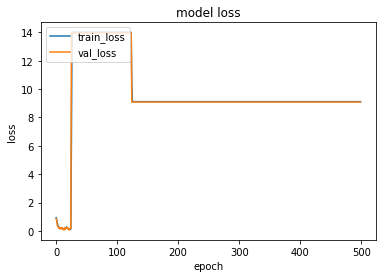

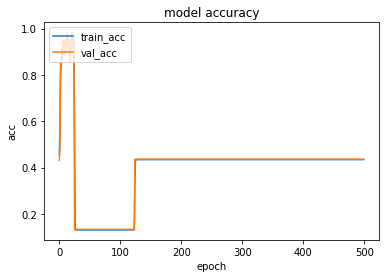

383/383 [==============================] - 1s 3ms/sample - loss: 9.0901 - acc: 0.4360

Test result: 43.603 loss: 9.090
[9.09010085082241, 0.43603134]
[242, 96, 315, 115, 260, 556, 284, 652, 363, 814, 118, 524, 433, 339, 434, 272, 28, 445, 698, 1054, 633, 772, 580, 417, 231, 79, 235, 169, 318, 7, 332, 644, 355, 86, 99, 824, 709, 727, 391, 908, 703, 43, 658, 680, 215, 1033, 638, 1079, 269, 63, 740, 258, 457, 1036, 176, 171, 730, 1044, 960, 91, 1014, 549, 309, 420, 1116, 308, 82, 428, 77, 546, 468, 883, 783, 968, 422, 155, 682, 606, 40, 425, 543, 808, 334, 504, 536, 802, 18, 253, 752, 498, 929, 283, 376, 328, 412, 780, 27, 201, 1037, 962, 305, 285, 859, 641, 884, 1100, 892, 932, 237, 399, 233, 767, 175, 10, 1129, 500, 1025, 1107, 1114, 818, 1072, 766, 162, 687, 639, 451, 1134, 961, 891, 834, 851, 436, 689, 805, 866, 1005, 94, 852, 393, 67, 371, 710, 1142, 1083, 938, 729, 73, 656, 950, 815, 54, 470, 980, 1135, 953, 1098, 967, 218, 538, 595, 888, 496, 1080, 914, 898, 1020, 845, 762, 191, 98

In [0]:
# load all data
data, label, _ , _ = load_data(128, 0)

# Cross validation, generate index for each fold
folds = cross_validation_split(range(len(data)),3)

# Grid Search for number of filters and kernel size
num_filter_list = [[6,16]]
kernel_size_list = [[5,5]]

result = []
for num_filter in num_filter_list:
  for kernel_size in kernel_size_list:
    
    # Train for each fold
    for fold_id in range(len(folds)):
      
      # Get test data for current fold
      test_id = folds[fold_id]
      test_data = data[test_id]
      test_label = label[test_id]
      
      
      # Get train data
      train_id = []
      for i in range(len(folds)):
        if i != test_id:
          train_id += folds[i]
      print(train_id)
      
      train_data = data[train_id]
      train_label = label[train_id]
      
      
      # Build model
      model = cnn_model_fn(num_filter, kernel_size) 
      model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

      # Training
      model.fit(train_data ,train_label, batch_size = 64, epochs = 500, validation_data=(test_data,test_label))#, callbacks=[tensorboard, checkpoint])
      
      # Plot loss and accuracy graph
      plotLoss(model.history)

      # Testing
      scores = model.evaluate(test_data, test_label, batch_size=1, verbose=1)
      print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
      print(scores)
      result.append([num_filter, kernel_size, test_id, scores[1]*100])


result = pd.DataFrame(result, columns = ['num_filter', 'kernel_size','fold', 'acc'])
result.to_csv('result.csv')

In [0]:
# Save model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


In [0]:
# def cnn_model_function(input_shape, filter_num, kernel_size):
#   model = Sequential()
#   #Layer 1
#   #Conv Layer 1
#   model.add(Conv2D(filters = filter_num[0], 
#                    kernel_size = kernel_size[0], 
#                    strides = 1, 
#                    activation = 'relu', 
#                    input_shape = (input_shape,input_shape,3)))
#   #Pooling layer 1
#   model.add(MaxPooling2D(pool_size = 2, strides = 2))
#   #Layer 2
#   #Conv Layer 2
#   model.add(Conv2D(filters = filter_num[1], 
#                    kernel_size = kernel_size[0],
#                    strides = 1,
#                    activation = 'relu',
#                    input_shape = (input_shape/2,input_shape/2,6)))
#   #Pooling Layer 2
#   model.add(MaxPooling2D(pool_size = 2, strides = 2))
#   #Flatten
#   model.add(Flatten())
#   return model

# def cnn_model_function(input_shape, filter_num, kernel_size):
#   input_layer = Input(shape=(input_shape, input_shape,3,))
#   #Layer 1
#   #Conv Layer 1
#   conv_layer1 = Conv2D(filters = filter_num[0], 
#                    kernel_size = kernel_size[0], 
#                    strides = 1, 
#                    activation = 'relu')(input_layer)
#   #Pooling layer 1
#   max_layer1 = MaxPooling2D(pool_size = 2, strides = 2)(conv_layer1)
#   #Layer 2
#   #Conv Layer 2
#   conv_layer2 = Conv2D(filters = filter_num[1], 
#                    kernel_size = kernel_size[0], 
#                    strides = 1, 
#                    activation = 'relu')(max_layer1)
#   #Pooling Layer 2
#   max_layer2 = MaxPooling2D(pool_size = 2, strides = 2)(conv_layer2)
#   #Flatten
#   flat = Flatten()(max_layer2)  
#   return flat, input_layer

In [0]:
# Double CNN

# train_data1, train_label1, test_data1, test_label1 = load_data(128)
# train_data2, train_label2, test_data2, test_label2 = load_data(64)

# random.seed(31)
# cnn1, input1 = cnn_model_function(128, [64, 256], [36, 2])
# cnn2, input2 = cnn_model_function(64, [32, 128], [12, 3])

# #concat_layer = Concatenate([cnn1, cnn2])
# concat_layer = keras.layers.concatenate([cnn1, cnn2])


# fully_connected1 = Dense(units = 1000, activation = 'relu')(concat_layer)
# fully_connected2 = Dense(units = 512, activation = 'relu')(fully_connected1)

# #Layer 5
# #Output Layer
# fully_connected3 = Dense(units = 3, activation = 'softmax')(fully_connected2)
# model = Model(inputs=[input1, input2], outputs=fully_connected3)
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.summary()

# model.fit(([train_data1, train_data2]) ,train_label1, batch_size = 64, epochs = 100, validation_data=(([test_data1, test_data2]),test_label1))